## CIS 520 Project (World Happiness Report Data)
Noah Hindes and Victor Phun



```
# This is formatted as code
```

## Imports and Data Setup

In [0]:
import sklearn as sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNet
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
! pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector

Read data from CSV into pandas dataframe:

In [0]:
whr_rawdata = pd.read_csv("whr_onlinedata.csv")

##Data Exploration, Visualization

In [0]:
#Quick look at table contents
whr_rawdata.head(20)

,Country name,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014"
0,Afghanistan,2008,3.723590,7.168690,0.450662,50.799999,0.718114,0.177889,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,1.774662,0.476600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2009,4.401778,7.333790,0.552308,51.200001,0.678896,0.200178,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,1.722688,0.391362,NaN,NaN,0.441906,0.286315,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,2010,4.758381,7.386629,0.539075,51.599998,0.600127,0.134353,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,1.878622,0.394803,NaN,NaN,0.327318,0.275833,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,2011,3.831719,7.415019,0.521104,51.919998,0.495901,0.172137,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,1.785360,0.465942,NaN,NaN,0.336764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,2012,3.782938,7.517126,0.520637,52.240002,0.530935,0.244273,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,1.798283,0.475367,NaN,NaN,0.344540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Afghanistan,2013,3.572100,7.522238,0.483552,52.560001,0.577955,0.070403,0.823204,0.620585,0.273328,0.482847,-1.879709,-1.403036,1.223690,0.342569,NaN,NaN,0.304368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Afghanistan,2014,3.130896,7.516955,0.525568,52.880001,0.508514,0.113184,0.871242,0.531691,0.374861,0.409048,-1.773257,-1.312503,1.395396,0.445686,NaN,NaN,0.413974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Afghanistan,2015,3.982855,7.500539,0.528597,53.200001,0.388928,0.089091,0.880638,0.553553,0.339276,0.260557,-1.844364,-1.291594,2.160618,0.542480,NaN,NaN,0.596918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Afghanistan,2016,4.220169,7.497038,0.559072,53.000000,0.522566,0.051365,0.793246,0.564953,0.348332,0.324990,-1.855426,-1.392713,1.796219,0.425627,NaN,NaN,0.418629,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Afghanistan,2017,2.661718,7.497755,0.490880,52.799999,0.427011,-0.112198,0.954393,0.496349,0.371326,0.261179,-1.886566,-1.437808,1.454051,0.546283,NaN,NaN,0.286599,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Graph the Life Ladder score against the Log GDP Per Capita in a scatter plot:

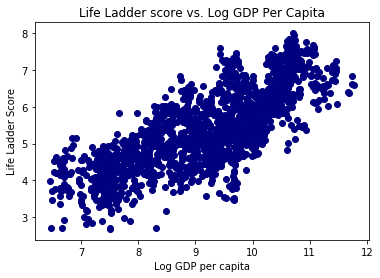

In [0]:

gdp_pc = np.array(whr_rawdata['Log GDP per capita'])
ladder = np.array(whr_rawdata['Life Ladder'])

plt.scatter(gdp_pc,ladder,color='navy',label='0')

plt.xlabel('Log GDP per capita')
plt.ylabel('Life Ladder Score')
plt.title("Life Ladder score vs. Log GDP Per Capita")
plt.show()
plt.close()

This plot in particular suggests the need for a sophisticated model to analyze Ladder score drivers--although we can see the correlation between Log GDP and Ladder score, it is perhaps surprising to note the width of the distribution, i.e. number of country-year entries which share same approximate Ladder despite wildly different GDP.

###Additional data preparation steps:


In [0]:
#Limit the dataset to only 2018.
whr_2018_raw = whr_rawdata[whr_rawdata['Year']==2018]

In [0]:
#Convert the pandas dataframe to a numpy array.
for_np = whr_rawdata[['Life Ladder','Log GDP per capita','Social support','Healthy life expectancy at birth','Freedom to make life choices','Generosity','Perceptions of corruption']]

For retrospective analysis, WHR article suggests six most important (largest-coefficient) features from its dataset and shares their OLS regression coefficients. For a predictive model, we wish to make use of, or at least assess potential value of, all available UN data:

In [0]:
#Expand selection of features beyond those used in WHR article:
addl_columns = whr_rawdata[['Life Ladder',
                            'Log GDP per capita',
                            'Social support',
                            'Healthy life expectancy at birth',
                            'Freedom to make life choices',
                            'Generosity',
                            'Perceptions of corruption',
                            'Positive affect',
                            'Negative affect',
                            'Democratic Quality',
                            'Delivery Quality',
                            'GINI index (World Bank estimate), average 2000-16'
                            ]]

In [0]:
#Use a mean imputation on the nulls in the dataset, then compare the size to a dataset with nulls dropped.
imp = IterativeImputer()
imp.fit(for_np)
for_np_imputed = imp.transform(for_np)
array_for_sklearn = np.array(for_np_imputed)
array_for_sklearn_dropped = np.array(for_np.dropna())
print(array_for_sklearn.shape)
print(array_for_sklearn_dropped.shape)

imp.fit(addl_columns)
addl_columns_imputed = imp.transform(addl_columns)
array_for_sklearn_addl = np.array(addl_columns_imputed)

(1704, 7)
(1516, 7)


We will proceed using imputed values.

In [0]:
#Split the dataset into X and Y for the imputed and null-dropped datasets.
X_whr = array_for_sklearn[:,1:]
y_whr = array_for_sklearn[:,0]
X_whr_na = array_for_sklearn_dropped[:,1:]
y_whr_na = array_for_sklearn_dropped[:,0]

## OLS Regression

In [0]:
#Use OLS regression like the UN study did on our mean imputed and null-dropped Xs and Ys.
whr_ols = LinearRegression()
whr_ols_reg = whr_ols.fit(X_whr,y_whr)
whr_ols_na = LinearRegression()
whr_ols_reg_na = whr_ols.fit(X_whr_na,y_whr_na)

print(whr_ols_reg.coef_)
print(whr_ols_reg_na.coef_)

scores_ols = cross_validate(whr_ols, X_whr, y_whr, 
                                    cv=4,#using 4 for now
                                    scoring=('neg_mean_squared_error')
                                    )
mse_ols = -1*np.mean(scores_ols['test_score'])
print(mse_ols)

[ 0.32755251  2.4727108   0.03109864  1.01786092  0.68353747 -0.55043552]
[ 0.32755251  2.4727108   0.03109864  1.01786092  0.68353747 -0.55043552]
0.3538104888363293


Very nearly replicates coefficients reported in WHR report ( [ 0.318, 2.422, 0.033, 1.164, 0.635, -0.540 ] )

Treat the MSE (0.3538) on predicted Ladder score as our baseline error.

## Elastic Net

Having confirmed OLS baseline, sensible next step in attempting to produce a predictive model would be regularization, here via ElasticNet loss function. We compare ElasticNet for original vs extended data columns using 4-fold cross validation; unwilling to increase folds due to small size (~160) of dataset. Grid search over EN penalty:


In [0]:
elasticnet_penalties = [0, 0.00001, 0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000,10000]
mse_orig = []
mse_extend = []

X_whr = array_for_sklearn[:,1:]
y_whr = array_for_sklearn[:,0]
X_extended = array_for_sklearn_addl[:,1:]
y_extended = array_for_sklearn_addl[:,0]

for en_lambda in elasticnet_penalties:
  e_n_model = ElasticNet(alpha = en_lambda, max_iter = 10000)
  
  orig_this_alpha = cross_validate(e_n_model, X_whr, y_whr, 
                                     cv=4,#using 4 for now
                                     scoring=('neg_mean_squared_error')
                                     )
  orig_mse = -1*np.mean(orig_this_alpha['test_score'])
  mse_orig.append(orig_mse)
  print("with alpha =",en_lambda,", mean test score (mse) for ORIGINAL was: ",orig_mse)

  extended_this_alpha = cross_validate(e_n_model, X_extended, y_extended, 
                                     cv=4,#using 4 for now
                                     scoring=('neg_mean_squared_error')
                                     )
  extended_mse = -1*np.mean(extended_this_alpha['test_score'])
  mse_extend.append(extended_mse)
  print("with alpha =",en_lambda,", mean test score (mse) for EXTENDED was: ",extended_mse)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.2967853271606, tolerance: 0.14729644892478033
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-

with alpha = 0 , mean test score (mse) for ORIGINAL was:  0.35381048883633115


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.1452769695983, tolerance: 0.14729644892478033
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.60469441757186, tolerance: 0.17150445247784868
  positive)
/usr/local/lib/py

with alpha = 0 , mean test score (mse) for EXTENDED was:  0.32652762803822805
with alpha = 1e-05 , mean test score (mse) for ORIGINAL was:  0.35380596475769716
with alpha = 1e-05 , mean test score (mse) for EXTENDED was:  0.3264988924129414
with alpha = 0.0001 , mean test score (mse) for ORIGINAL was:  0.3537739184385008
with alpha = 0.0001 , mean test score (mse) for EXTENDED was:  0.3262568620537787
with alpha = 0.001 , mean test score (mse) for ORIGINAL was:  0.35375625540067046
with alpha = 0.001 , mean test score (mse) for EXTENDED was:  0.32486355536528444
with alpha = 0.01 , mean test score (mse) for ORIGINAL was:  0.36903798707569874
with alpha = 0.01 , mean test score (mse) for EXTENDED was:  0.3419152991767818
with alpha = 0.1 , mean test score (mse) for ORIGINAL was:  0.4859506050609808
with alpha = 0.1 , mean test score (mse) for EXTENDED was:  0.46462929034333456
with alpha = 1.0 , mean test score (mse) for ORIGINAL was:  0.5830618881800438
with alpha = 1.0 , mean test sco

Results shown graphically and discussed below:

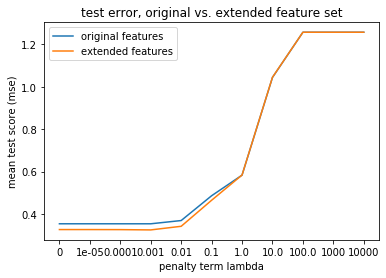

In [0]:
orig = list(mse_orig)
ext = list(mse_extend)
enp = list(map(str, elasticnet_penalties))


plt.plot(enp,orig,label='original features')
plt.plot(enp,ext,label='extended features')
plt.xlabel('penalty term lambda')
plt.legend()
plt.ylabel('mean test score (mse)')
plt.title('test error, original vs. extended feature set')
plt.show()
plt.close()

For all but the largest regularization penalties, we see slightly better test-set performance (here, average of the four cross-validation MSE values) with **the extended feature set**. In particular, an extended feature set with penalty weight 0.001 has MSE of 0.3248, just slightly better than our baseline OLS on limited features (0.3538). Note that the Cantril Ladder is on a 0-10 scale. 

By exploring a wide range of penalty weights, we can be more confident that introducing these new features does not expose us to severe overfitting.

## Feature Selection - Streamwise

So far we have worked with two discrete subsets of our available features, with no comments on autocorrelation. Can we improve our model by judiciously selecting from the pool of available features?

In [0]:
#STREAMWISE (FORWARD) feature selection (implemented ourselves):

def elasticnet_feature_selection(current_alpha, X, y):

  #initialize mse for a model w/ all zeros:
  best_mse_so_far = np.sum(np.square(y))/len(y)
  included_feature_indices = ([False]*len(X[0])*len(X)) 

  included_features = []
  feature_data = np.array([[0]]*len(X))


  for i in range(0,len(X[0])):
    current_feature_data = feature_data
    e_n_model = ElasticNet(alpha = current_alpha, max_iter = 10000)

    #TRY ADDING CURRENT FEATURE:
    current_feature_data = np.append(current_feature_data,np.reshape(X[:,i],[len(X),1]),1)
    e_n_model = ElasticNet(alpha = current_alpha, max_iter = 10000)

    scores_this_alpha = cross_validate(e_n_model, current_feature_data, y, 
                                     cv=4,#using 4 for now
                                     scoring=('neg_mean_squared_error')
                                     )
    current_mse = -1*np.mean(scores_this_alpha['test_score'])
    #USE FOLLOWING LINE TO SEE MSE FOR EACH NEW FEATURE TEST IN STREAMWISE:
    #print("with alpha =",current_alpha,", mean test score (mse) was: ",current_mse)
    if (current_mse < best_mse_so_far):
      best_mse_so_far = current_mse
      included_features.append(i)
      feature_data = current_feature_data

  print("best mse for the feature selection step with penalty ",current_alpha," is ", best_mse_so_far)  
  print("corresponding included features: ", included_features)  
  return best_mse_so_far, included_features

In [0]:
#ElasticNet on streamwise feature selection

elasticnet_penalties = [0, 0.00001, 0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000,10000]
mse_streamwise = []
optimal_num_features = []

best_alpha = -999
best_mse = float("inf") #will update this to determine best alpha
best_feature_set = []

#iterate thru hyperparameter values
for current_alpha in elasticnet_penalties:
  mse_this_alpha, features_this_alpha = elasticnet_feature_selection(current_alpha, X_extended,y_extended) #will need to refactor and use different args
  
  if(mse_this_alpha<best_mse):
    best_mse = mse_this_alpha
    best_alpha = current_alpha
    best_feature_set.append(features_this_alpha)

  mse_streamwise.append(mse_this_alpha)
  optimal_num_features.append(len(features_this_alpha))

print("\noptimal value for hyperparameter alpha (elastic net penalty): ",best_alpha)
print("optimal features are: ",print(best_feature_set))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.12582661500255, tolerance: 0.14729644892478033
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist

best mse for the feature selection step with penalty  0  is  0.3200235088706084
corresponding included features:  [0, 1, 2, 3, 4, 5, 6, 8]
best mse for the feature selection step with penalty  1e-05  is  0.32002044123900253
corresponding included features:  [0, 1, 2, 3, 4, 5, 6, 8]
best mse for the feature selection step with penalty  0.0001  is  0.319998376955054
corresponding included features:  [0, 1, 2, 3, 4, 5, 6, 8]
best mse for the feature selection step with penalty  0.001  is  0.32017299878372363
corresponding included features:  [0, 1, 2, 3, 4, 5, 6, 8]
best mse for the feature selection step with penalty  0.01  is  0.33871545655148866
corresponding included features:  [0, 1, 2, 3, 4, 5, 6, 8]
best mse for the feature selection step with penalty  0.1  is  0.4646292903433346
corresponding included features:  [0, 2, 8, 9]
best mse for the feature selection step with penalty  1.0  is  0.583561245705608
corresponding included features:  [0, 2]
best mse for the feature selection s

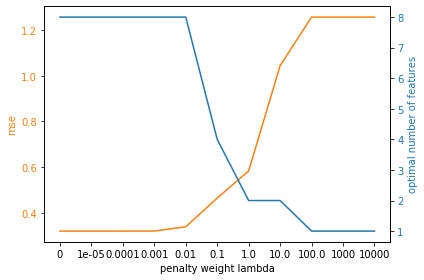

In [0]:
#STREAMWISE FEATURE SELECTION: mse vs optimal # of features

ext = list(mse_streamwise)
nf = list(optimal_num_features)
enp = list(map(str, elasticnet_penalties))

fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('penalty weight lambda')
ax1.set_ylabel('mse', color=color)
ax1.plot(enp, ext, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('optimal number of features', color=color)  # we already handled the x-label with ax1
ax2.plot(enp, nf, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()



We do not start out using all 11 features--for small penalties there appear to be 8 (from an arbitary fixed order) that help us.

Note that even with this naive (depends on order in which features assessed) approach, we see slight improvement in performance: with lambda = 0.0001, we see the lowest mse achieved so far (0.3199). Moreover, note that of our 10 features only eight are included ('Negative affect', 'Delivery Quality' and 'GINI index' are tossed out). 

'Affect' survey relates to respondents' reported mood, and it is perhaps unsurprising that we would only keep 'Positive affect'--by design, we would expect it to be more or less mutually exclusive with 'Negative affect'. 

Inclusion of another government-effectiveness score, 'Democratic Quality' may allow respondents to explain away variation in government 'Delivery Quality'.

Perhaps the most perplexing is the exclusion of GINI coefficient (measure of income inequality); the fact that it appears last in this streamwise selection seems a likely explanation as to how it can be excluded.


##Feature Selection - Stepwise

In [0]:
#STEPWISE (FORWARD) FEATURE SELECTION (used mlextend library):

elasticnet_penalties = [0, 0.00001, 0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000,10000]
feature_names = [
                          'Log GDP per capita',
                          'Social support',
                          'Healthy life expectancy at birth',
                          'Freedom to make life choices',
                          'Generosity',
                          'Perceptions of corruption',
                          'Positive affect',
                          'Negative affect',
                          'Democratic Quality',
                          'Delivery Quality',
                          'GINI index (World Bank estimate), average 2000-16'
                          ]

mse_stepwise = []
optimal_num_features = []


for penalty in elasticnet_penalties:
  best_score_this_lambda = 999
  best_k_this_lambda = 0
  best_features_this_lambda = []
  for best_k in range(1,12):
    feature_selector = SequentialFeatureSelector(ElasticNet(alpha = penalty, max_iter = 10000),
              k_features=best_k,
              forward=True,
              verbose=0,
              scoring='neg_mean_squared_error',
              cv=4)

    features = feature_selector.fit(X_extended, y_extended)
    score_this_k = -1*features.k_score_
    if score_this_k < best_score_this_lambda:
      best_k_this_lambda = best_k
      best_score_this_lambda = score_this_k
      best_features_this_lambda = np.array(feature_names)[list(features.k_feature_idx_)]


  mse_stepwise.append(best_score_this_lambda)
  optimal_num_features.append(len(best_features_this_lambda))
  print ("\nselected_features for penalty weight: ",penalty," \n",best_features_this_lambda, " (mse: ",best_score_this_lambda,")")


  #print(features.k_feature_idx_)
  #selected_features = np.array(feature_names)[list(features.k_feature_idx_)]
  #print ("\nselected_features for penalty weight: ",penalty," \n",selected_features)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.12582661500255, tolerance: 0.14729644892478033
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist


selected_features for penalty weight:  0  
 ['Log GDP per capita' 'Social support' 'Healthy life expectancy at birth'
 'Generosity' 'Perceptions of corruption' 'Positive affect'
 'Democratic Quality']  (mse:  0.31978564690061345 )

selected_features for penalty weight:  1e-05  
 ['Log GDP per capita' 'Social support' 'Healthy life expectancy at birth'
 'Generosity' 'Perceptions of corruption' 'Positive affect'
 'Democratic Quality']  (mse:  0.31978241177361694 )

selected_features for penalty weight:  0.0001  
 ['Log GDP per capita' 'Social support' 'Healthy life expectancy at birth'
 'Generosity' 'Perceptions of corruption' 'Positive affect'
 'Democratic Quality']  (mse:  0.3197583996028711 )

selected_features for penalty weight:  0.001  
 ['Log GDP per capita' 'Social support' 'Healthy life expectancy at birth'
 'Generosity' 'Perceptions of corruption' 'Positive affect'
 'Democratic Quality']  (mse:  0.31991405071449364 )

selected_features for penalty weight:  0.01  
 ['Log GDP pe

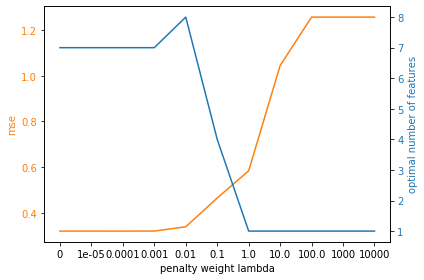

In [0]:
#STEPWISE FEATURE SELECTION: mse vs optimal # of features

ext = list(mse_stepwise)
nf = list(optimal_num_features)
enp = list(map(str, elasticnet_penalties))

fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('penalty weight lambda')
ax1.set_ylabel('mse', color=color)
ax1.plot(enp, ext, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('optimal number of features', color=color)  # we already handled the x-label with ax1
ax2.plot(enp, nf, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()



It is unsurprising that this method alights on a slightly smaller set of features (7 vs streamwise's 8 at small penalty weights) given that it can choose the 'next best' one with each iteration.

In terms of the spike to 8 features at lambda = 0.01 is difficult ot interpret. This is the only model that uses the "Freedom to Make Life Decisions" score and is otherwise indistinguishable from its predecessors' features.

We find our best MSE among all experimental methods here for lambda = 0.0001 (mse = 0.3198).

## Principal Component Analysis and Regression

We decided to use the expanded feature set found from the feature selection in PCA and PCR, as having more features would allow for a better distribution and analysis. How many components could we reduce the dataset to while still maintaining a comparable mean squared error?

In [0]:
#Use PCA using a set number of components and find percent error to original matrix using Frobenius norm.
#Then, use the reconstructed X matrix to compare the MSE scores to without PCA.
X_addl = array_for_sklearn_addl[:,1:]
# y_addl = array_for_sklearn_addl[:,0]
n_components = [1,2,3,4,5,6,7,8,9,10,11] 
pca_ols_scores = []
no_pca_ols_scores = []
pca_en_scores = []
no_pca_en_scores = []
for n in n_components:
  pca = PCA(n_components=n)
  pca_components = pca.fit_transform(X_addl)
  X_pca = pca.inverse_transform(pca_components)
  print(str(n) + " Components:")
  percent_error = abs(np.linalg.norm(pca_components) - np.linalg.norm(X_addl)) / (np.linalg.norm(X_addl)) * 100
  print("Percent Error of Frobenius Norms of reconstructed/normal components: " + str(percent_error) + "%")
  print("OLS Results:")
  whr_ols = LinearRegression()
  whr_ols_reg = whr_ols.fit(X_addl,y_whr)
  whr_ols_pca = LinearRegression()
  whr_ols_pca_reg = whr_ols_pca.fit(X_pca,y_whr)
  score_ols = -1 * np.mean(cross_validate(whr_ols, X_addl, y_whr, 
                                     cv=4,#using 4 for now
                                     scoring=('neg_mean_squared_error')
                                     )['test_score'])
  score_ols_pca = -1 * np.mean(cross_validate(whr_ols_pca_reg, pca_components, y_whr, 
                                     cv=4,#using 4 for now
                                     scoring=('neg_mean_squared_error')
                                     )['test_score'])
  print("No PCA: " + str(score_ols))
  print("W/ PCA: " + str(score_ols_pca))
  print("Elastic Net:")
  e_n_model = ElasticNet(alpha = 1e-05, max_iter = 100000)
  score_en = -1 * np.mean(cross_validate(e_n_model, X_addl, y_whr, 
                                     cv=4,#using 4 for now
                                     scoring=('neg_mean_squared_error')
                                     )['test_score'])
  score_en_pca = -1 * np.mean(cross_validate(e_n_model, pca_components, y_whr, 
                                     cv=4,#using 4 for now
                                     scoring=('neg_mean_squared_error')
                                     )['test_score'])
  print("No PCA: " + str(score_en))
  print("W/ PCA: " + str(score_en_pca))
  pca_ols_scores.append(score_ols_pca)
  no_pca_ols_scores.append(score_ols)
  pca_en_scores.append(score_en_pca)
  no_pca_en_scores.append(score_en)
  print("============================")

1 Components:
Percent Error of Frobenius Norms of reconstructed/normal components: 88.09285952099917%
OLS Results:
No PCA: 0.326527628038227
W/ PCA: 0.5657581282066032
Elastic Net:
No PCA: 0.3264988924129414
W/ PCA: 0.565758129774731
2 Components:
Percent Error of Frobenius Norms of reconstructed/normal components: 88.0040527427002%
OLS Results:
No PCA: 0.326527628038227
W/ PCA: 0.46237098594804893
Elastic Net:
No PCA: 0.3264988924129414
W/ PCA: 0.4623710039435802
3 Components:
Percent Error of Frobenius Norms of reconstructed/normal components: 87.97231327049057%
OLS Results:
No PCA: 0.326527628038227
W/ PCA: 0.4511794412076061
Elastic Net:
No PCA: 0.3264988924129414
W/ PCA: 0.45117936038159034
4 Components:
Percent Error of Frobenius Norms of reconstructed/normal components: 87.96176113656009%
OLS Results:
No PCA: 0.326527628038227
W/ PCA: 0.45254408736707674
Elastic Net:
No PCA: 0.3264988924129414
W/ PCA: 0.4525439100442735
5 Components:
Percent Error of Frobenius Norms of reconstru

As a sanity check, we confirmed that 11 components fully reconstructs original (11-feature) input.

Text(0.5, 1.0, 'Comparison of OLS Scores with and without PCA')

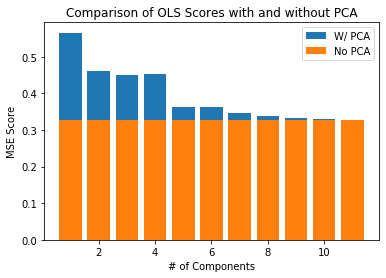

In [0]:
plt.bar(n_components, pca_ols_scores, width=0.8, label='W/ PCA')
plt.bar(n_components, no_pca_ols_scores, width=0.8, label='No PCA')
plt.ylabel("MSE Score")
plt.xlabel("# of Components")
plt.legend(loc="upper right")
plt.title("Comparison of OLS Scores with and without PCA")

Text(0.5, 1.0, 'Comparison of Elastic Net Scores with and without PCA')

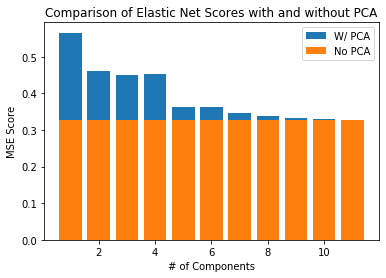

In [0]:
plt.bar(n_components, pca_en_scores, width=0.8, label='W/ PCA')
plt.bar(n_components, no_pca_en_scores, width=0.8, label='No PCA')
plt.ylabel("MSE Score")
plt.xlabel("# of Components")
plt.legend(loc="upper right")
plt.title("Comparison of Elastic Net Scores with and without PCA")

The graphs show that as the number of components increase, the MSE between the original and reconstructed models decreases. Our dataset is not large enough for us to need to use PCA to reduce dimensionality, but the results show that it would be a viable option if needed.

## K-Means Clustering

We first used to elbow method to try and find the optimal number of clusters.

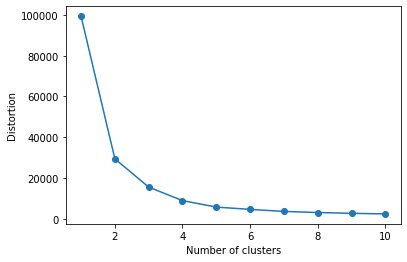

In [0]:
# Use the elbow method to find best number of clusters
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

km = KMeans()
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(X_whr)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

It is a little hard to tell, but it appears that the distortion starts to flatline at around 4 clusters. With this information, we fit our K-means model to the dataset with 4 clusters.

In [0]:
#Declare a KMeans model using the number of clusters found from the elbow method.
#Fit our X to it and print out the centroids to find tha values of each of the features for each cluster.

km = KMeans(n_clusters=4, random_state=0)
classes_km = km.fit_predict(X_whr)
km_centroids = km.cluster_centers_
print(km_centroids)

[[ 1.05141196e+01  9.06098623e-01  7.16659128e+01  8.33795974e-01
   7.27984842e-02  6.03705766e-01]
 [ 7.53325711e+00  6.91278395e-01  4.88898618e+01  6.58914096e-01
   1.16356068e-02  8.08190699e-01]
 [ 9.45736576e+00  8.31168022e-01  6.53741916e+01  7.18238632e-01
  -5.05413693e-02  7.94521124e-01]
 [ 8.30095915e+00  7.35562707e-01  5.75286326e+01  6.97182725e-01
   1.51806485e-02  7.89639913e-01]]


As a final sanity check, we looped through a number of clusters, predicted the ladder rating based on the cluster, and printed out a mean squared error of the predicted y and the actual y.

In [0]:
#Loop through the 1 to 10 clusters to compare the MSE score and predicted y of each
num_clusters = [1,2,3,4,5,6,7,8,9,10,1704] 
print(len(X_whr))
cluster_scores = []
for n in num_clusters:
  print(str(n) + " Cluster(s):")
  km = KMeans(n_clusters=n, random_state=0).fit(X_whr)
  labels = km.labels_
  avg_ladder_scores = []

  labels_with_ladder = np.column_stack((labels,y_whr))
  for i in range(0, n):
    ladders_of_i = labels_with_ladder[labels_with_ladder[:,0] ==  i]
    avg_ladder = np.mean(ladders_of_i[:,1])
    avg_ladder_scores.append(avg_ladder)
  print("Predicted ladder scores per Cluster: " + str(avg_ladder_scores))

  ladders_per_label = []
  for j in range(0, len(labels)):
    ladders_per_label.append(avg_ladder_scores[labels[j]])

  score_km = (np.square(y_whr - ladders_per_label)).mean()
  cluster_scores.append(score_km)
  print("MSE score: " + str(score_km))
  print("===============================================")

1704
1 Cluster(s):
Predicted ladder scores per Cluster: [5.437155035744718]
MSE score: 1.2562375919499928
2 Cluster(s):
Predicted ladder scores per Cluster: [4.350879725312618, 5.9288960330502976]
MSE score: 0.7220714874496833
3 Cluster(s):
Predicted ladder scores per Cluster: [4.261420340288509, 6.584553007157258, 5.326724618499374]
MSE score: 0.5355094997823704
4 Cluster(s):
Predicted ladder scores per Cluster: [6.717274696129585, 4.214949513368664, 5.528022724511173, 4.543752803980663]
MSE score: 0.4996465416678599
5 Cluster(s):
Predicted ladder scores per Cluster: [6.754187938610355, 4.263552880738563, 5.021552925813725, 4.258196958472222, 5.629617871968051]
MSE score: 0.5088020512866932
6 Cluster(s):
Predicted ladder scores per Cluster: [6.769043097320226, 4.301179633404411, 5.391792850460815, 4.217145919801802, 5.73098497767191, 4.706618493641593]
MSE score: 0.4950077594696217
7 Cluster(s):
Predicted ladder scores per Cluster: [6.773453828474777, 4.234682337, 5.413810947840971, 4

Sanity check--clustering on full dataset has reconstruction error 0.

Text(0.5, 1.0, 'MSE Score vs. # of Clusters')

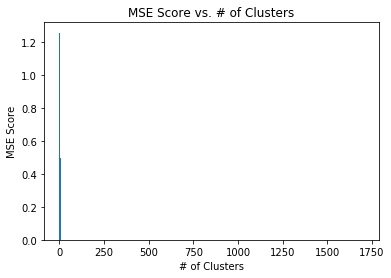

In [0]:
plt.bar(num_clusters,cluster_scores)
plt.ylabel("MSE Score")
plt.xlabel("# of Clusters")
plt.title("MSE Score vs. # of Clusters")

We can see that 4 was a correct assumption, as the MSE stays relatively constant after that.